In [145]:
from google.colab import drive
gdrive_mount_path = ''
drive.mount('/content/drive/', force_remount=True)

root_folder_path = '/content/drive/MyDrive/Colab Notebooks/Deep-Learning-LW1/'
images_folder_path = root_folder_path + 'images/'
model_file_name = 'model.pkl'

img_size = 32

Mounted at /content/drive/


In [146]:
import pandas as pd
import pickle
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from google.colab import files
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
from PIL import Image
from os import listdir
from os.path import isfile, join

In [147]:
class SvhnModel(nn.Module):
    """Feedfoward neural network with 6 hidden layer"""
    def __init__(self, in_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 256)
        self.linear4 = nn.Linear(256, 128)
        self.linear5 = nn.Linear(128, 64)
        self.linear6 = nn.Linear(64, 32)
        # output layer
        self.linear7 = nn.Linear(32, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)

        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        out = F.relu(out)
        out = self.linear6(out)
        out = F.relu(out)

        # Get predictions using output layer
        out = self.linear7(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [148]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for batch in self.dataloader: 
            yield to_device(batch, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [149]:
def to_device(data, device):
    # if (device != "cuda"):
    #     raise SystemExit
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [150]:
model = pickle.load(open(root_folder_path + model_file_name, 'rb'))

In [151]:
def img_to_tensor(img):
    resize = transforms.Resize([img_size, img_size])
    img = img.resize((img_size, img_size))
    to_tensor = transforms.ToTensor()
    img_tensor = to_tensor(img)
    return img_tensor.unsqueeze(0)

In [152]:
def plot_show_images_with_labels(images, labels):  
  fig, axes = plt.subplots(1, len(images), figsize=(16, 4*len(images)))
  for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])   
    ax.set_xticks([]); ax.set_yticks([])
    if (i+1 == len(images)):
      break

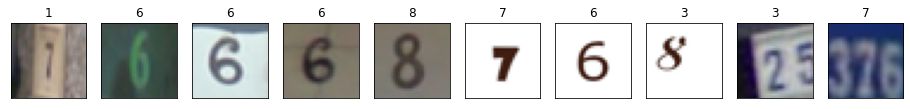

In [153]:
all_predictions = []
all_images = []

all_images_names = [f for f in listdir(images_folder_path) if isfile(join(images_folder_path, f))]

for img_name in all_images_names:
  img = Image.open(images_folder_path + img_name).convert('RGB')
  img_tensor = img_to_tensor(img)
  pred_tensor = model(img_tensor)

  transform = transforms.ToPILImage()
  img2 = transform(img_tensor[0])
  all_images.append(img2)

  _, pred = torch.max(pred_tensor, dim=1)
  all_predictions.append(int(pred[0]))

plot_show_images_with_labels(all_images, all_predictions)